In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Load the dataset
df = pd.read_csv('database.csv')

In [ ]:
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [ ]:
timestamp = []
for d, t in zip(df['Date'], df['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
df['Timestamp'] = timeStamp.values
df = df.drop(['Date', 'Time'], axis=1)
df = df[df.Timestamp != 'ValueError']
df.head(3)

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Timestamp
0,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,-157630542.0
1,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,-157465811.0
2,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,-157355642.0


In [ ]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# Time Series Analysis (ARIMA)
model_arima = ARIMA(train_data['Magnitude'], order=(1, 0, 0))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Neural Networks (LSTM)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Magnitude', 'Depth']])
test_scaled = scaler.transform(test_data[['Magnitude', 'Depth']])

In [ ]:
# Prepare the data for LSTM
def prepare_data(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 10
X_train, y_train = prepare_data(train_scaled, lookback)
X_test, y_test = prepare_data(test_scaled, lookback)

In [ ]:

# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(lookback, 2)))
model_lstm.add(Dense(2))
model_lstm.compile(optimizer='adam',metrics=['accuracy'], loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
585/585 [==============================] - 7s 9ms/step - loss: 0.0225
Epoch 2/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 3/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 4/50
585/585 [==============================] - 5s 8ms/step - loss: 0.0223
Epoch 5/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 6/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 7/50
585/585 [==============================] - 5s 8ms/step - loss: 0.0223
Epoch 8/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 9/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 10/50
585/585 [==============================] - 7s 12ms/step - loss: 0.0223
Epoch 11/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0222
Epoch 12/50
585/585 [==============================] - 4s 7ms/step - loss: 0.0223
Epoch 13/50
585/585 [==

In [ ]:
# Make predictions
arima_predictions = model_arima_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
lstm_predictions = model_lstm.predict(X_test)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


146/146 [==============================] - 1s 4ms/step


In [ ]:
import pandas as pd

In [ ]:
print(type(arima_predictions))

<class 'pandas.core.series.Series'>


In [ ]:
arima_predictions = arima_predictions.to_numpy()

In [ ]:
arima_predictions = arima_predictions.reshape(-1, 1)

In [ ]:
print(arima_predictions.shape)
print(lstm_predictions.shape)

(4682, 1)
(4672, 2)


In [ ]:
print(test_data.shape)

(4682, 20)


In [ ]:
arima_predictions = arima_predictions.reshape(-1, 1)
lstm_predictions = lstm_predictions.reshape(-1, 1)

In [ ]:
# Compare the predictions
test_data['ARIMA_Predictions'] = arima_predictions[:len(test_data)]
test_data['LSTM_Predictions'] = lstm_predictions[:len(test_data), 0]


<ipython-input-79-6db84fd14aef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA_Predictions'] = arima_predictions[:len(test_data)]
<ipython-input-79-6db84fd14aef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['LSTM_Predictions'] = lstm_predictions[:len(test_data), 0]


In [ ]:
# Evaluate the performance
arima_rmse = np.sqrt(np.mean((test_data['Magnitude'] - test_data['ARIMA_Predictions'])**2))
lstm_rmse = np.sqrt(np.mean((test_data['Magnitude'] - test_data['LSTM_Predictions'])**2))

In [ ]:
print("ARIMA RMSE:", arima_rmse)
print("LSTM RMSE:", lstm_rmse)

ARIMA RMSE: 0.43529154355824223
LSTM RMSE: 5.803116769903336


In [ ]:
# Calculate the percentage error
arima_percentage_error = np.mean(np.abs((test_data['Magnitude'] - test_data['ARIMA_Predictions']) / test_data['Magnitude'])) * 100
lstm_percentage_error = np.mean(np.abs((test_data['Magnitude'] - test_data['LSTM_Predictions']) / test_data['Magnitude'])) * 100

# Print the accuracy as a percentage
print("ARIMA Accuracy:", 100 - arima_percentage_error, "%")
print("LSTM Accuracy:", 100 - lstm_percentage_error, "%")

ARIMA Accuracy: 94.80705832341697 %
LSTM Accuracy: 1.7238733986225583 %


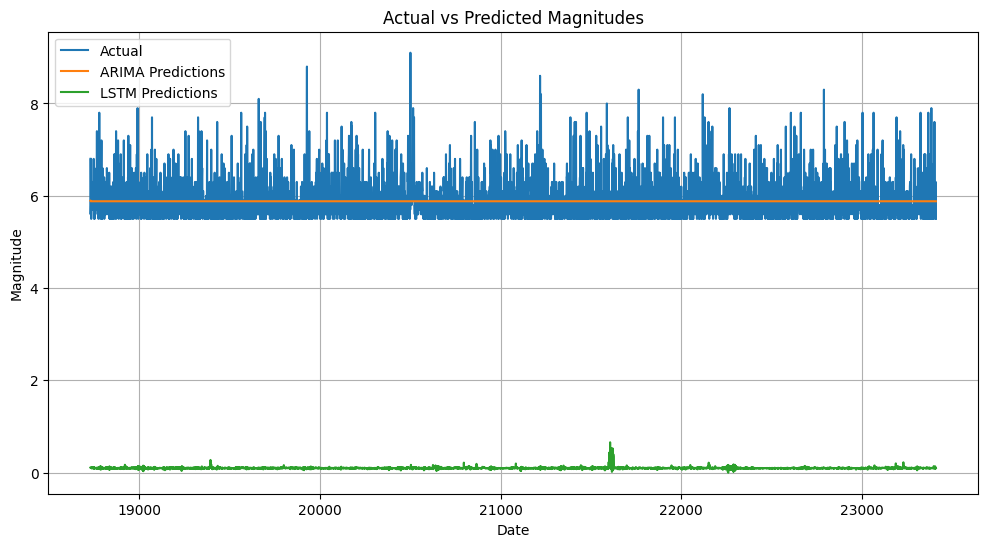

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual magnitudes and predicted magnitudes
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Magnitude'], label='Actual')
plt.plot(test_data.index, test_data['ARIMA_Predictions'], label='ARIMA Predictions')
plt.plot(test_data.index, test_data['LSTM_Predictions'], label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('Actual vs Predicted Magnitudes')
plt.legend()
plt.grid(True)
plt.show()